In [5]:
# TODO give the discriminator more time to train as described in the descriminator advantage global variable
# TODO make the generator connect up to a FC layer after convolutional upscaling
# TODO https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/78

import torch
import torch.utils.data.dataloader
import torch.nn as nn
from numpy import moveaxis

import matplotlib.pyplot as plt

CUDA_LAUNCH_BLOCKING=1

In [6]:
NUM_EPOCHS = 100
BATCH_SIZE = 15
DISCRIMINATOR_ADVANTAGE = 1
# GENERATOR_ADVANTAGE = 1
DISCRIMINATOR_LEARNING_RATE = 0.0005
GENERATOR_LEARNING_RATE = 0.001
LATENT_SPACE_SIZE = 100
IMAGE_SIZE = 28
CHANNEL_COUNT = 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

REAL_DATA_LABEL = 0
GENERATED_DATA_LABEL = 1

In [7]:
class Generator(nn.Module):
    def generate_hidden_layer(self, input_channels, output_channels, output_up_scaling_factor, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, output_up_scaling_factor, 1, padding),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU()
        )
        
    def __init__(self):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(LATENT_SPACE_SIZE, 400),
            nn.Tanh()
        )
        
        # self.layer2 = self.generate_hidden_layer(400, 200, 4, 0)    # 4x4 
        self.layer2 = self.generate_hidden_layer(LATENT_SPACE_SIZE, 100, 4, 0)    # 4x4 
        self.layer3 = self.generate_hidden_layer(100, 50, 5, 0)   # 8x8
        self.layer4 = self.generate_hidden_layer(50, 25, 9, 0)    # 16x16
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(25, CHANNEL_COUNT, 13, 1, 0),  # 28x28
            nn.BatchNorm2d(CHANNEL_COUNT),
            # nn.LeakyReLU()
            nn.Tanh()
        )

        
    def forward(self, x):
        """
        Args:
            x (torch.tensor): Some 1d tensor that consists of pure gaussian noise
        """
        # print(x.size())
        # x = self.layer1(x)
        # print(x.size())
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x
        
        
        
class Discriminator(nn.Module):
    def generate_convolutional_layer(self, in_channels, out_channels, convolution_kernel_size, pooling_kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, convolution_kernel_size, stride, padding=1),
            nn.AvgPool2d(pooling_kernel_size),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels)
        )
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.convolutional_layer1 = self.generate_convolutional_layer(CHANNEL_COUNT, 10, 3, 2, 1)
        self.convolutional_layer2 = self.generate_convolutional_layer(10, 30, 3, 2, 1) 
        self.convolutional_layer3 = self.generate_convolutional_layer(20, 40, 3, 2, 1)
        self.fully_connected1 = nn.Sequential(
            nn.LazyLinear(128),
            nn.LeakyReLU()
        )
        self.fully_connected2 = nn.Sequential(
            nn.LazyLinear(86),
            nn.LeakyReLU(),
        )
        self.fully_connected3 = nn.Sequential(
            nn.LazyLinear(1),
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        """
        Args:
            x (torch.tensor): Tensor that represents a 3x32x32 image
        """
        # print(x.size())
        x = self.convolutional_layer1(x)
        x = self.convolutional_layer2(x)
        # x = self.convolutional_layer3(x)
        x = x.view(x.size(0), -1)     # flatten each of the tensors in the batch so that we can feed it into the fully connected layer
        x = self.fully_connected1(x)
        # x = self.fully_connected2(x)
        return self.fully_connected3(x)
        # return x.view(-1)   # one other flatten to make sure everything lines up correctly

def generate_gaussian_noise(batch_size, dimensions):
    return torch.randn(batch_size, dimensions, 1, 1, device=DEVICE)

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# generator = Generator()
# generator.apply(weights_init)
# generator.to(DEVICE)
generator = Generator().to(DEVICE)
generator.load_state_dict(torch.load("models/generator_MNIST"))
generator_optimizer = torch.optim.Adam(generator.parameters(), GENERATOR_LEARNING_RATE/ DISCRIMINATOR_ADVANTAGE)
torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)

# discriminator = Discriminator()
# discriminator.apply(weights_init)
# discriminator.to(DEVICE)
discriminator = Discriminator().to(DEVICE)
discriminator.load_state_dict(torch.load("models/discriminator_MNIST"))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), DISCRIMINATOR_LEARNING_RATE)
torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)

# loss_function = nn.MSELoss()
loss_function = nn.BCELoss()

<Figure size 640x480 with 0 Axes>

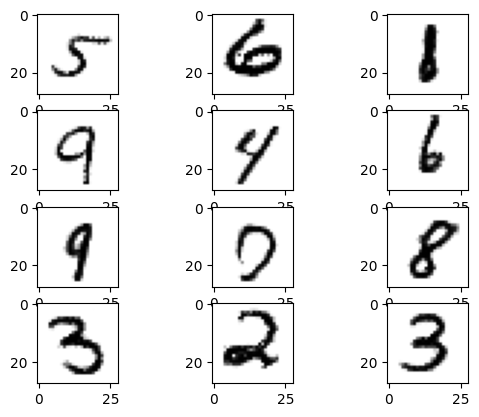

In [8]:
generator = Generator().to(DEVICE)
generator.load_state_dict(torch.load("models/generator_MNIST"))

discriminator = Discriminator().to(DEVICE)
discriminator.load_state_dict(torch.load("models/discriminator_MNIST"))

test_images = generator(generate_gaussian_noise(BATCH_SIZE, LATENT_SPACE_SIZE))
# print(test_images)
test_images = (-255 * ((test_images + 1)/ 2)).cpu().detach().numpy().astype(int)

test_images = moveaxis(test_images, 1, 3).astype(int)
plt.figure()
f, axarr = plt.subplots(4,3) 

for i in range(4):
    for j in range(3):
        axarr[i, j].imshow(test_images[i + j * 4], cmap="gray")
# axarr[0, 0].imshow(moveaxis(test_images[0], 0, 2).astype(int), cmap="gray")
# axarr[0,1].imshow(moveaxis(test_images[1], 0, 2).astype(int), cmap="gray")
# axarr[2].imshow(moveaxis(test_images[2], 0, 2).astype(int), cmap="gray")
# axarr[3].imshow(moveaxis(test_images[3], 0, 2).astype(int), cmap="gray")

# plt.imshow(test_image, cmap="gray")
